In [ ]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# Specify the path to the uploaded zip file
zip_path = '/content/drive/MyDrive/data.zip'

# Specify the destination folder to extract the dataset
extract_path = '/content'

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
dataset = Cityscapes('/content/data/', split='train', mode='fine',
                      target_type='semantic')

In [ ]:
dataset[0][0].size

(2048, 1024)

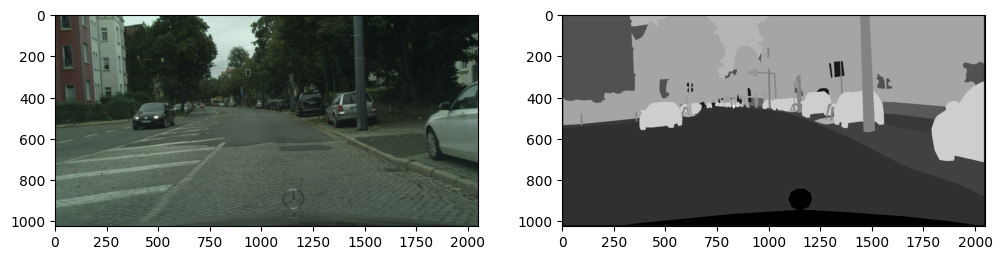

In [ ]:
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
ax[0].imshow(dataset[0][0])
ax[1].imshow(dataset[0][1],cmap='gray')

In [ ]:
ignore_index=255
void_classes = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,32,33, -1]
valid_classes = [ignore_index,7] 
class_names = ['unlabelled', 'road'] 

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_map

{255: 0, 7: 1}

In [ ]:
colors = [   [  0,   0,   0],
        [128, 64, 128],]
 

label_colours = dict(zip(range(n_classes), colors))

In [ ]:
def encode_segmap(mask):
    #remove unwanted classes and recitify the labels of wanted classes
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

In [ ]:
def decode_segmap(temp):
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
transform=A.Compose(
[
    A.Resize(256, 512),
    A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)

In [ ]:
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from torchvision.datasets import Cityscapes

class MyClass(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image = Image.open(self.images[index]).convert('RGB')

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])
            targets.append(target)
        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            transformed=transform(image=np.array(image), mask=np.array(target))            
        return transformed['image'],transformed['mask']
    #torch.unsqueeze(transformed['mask'],0)

In [ ]:
dataset=MyClass('/content/data/', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
img,seg= dataset[20]
print(img.shape,seg.shape)

torch.Size([3, 256, 512]) torch.Size([256, 512])


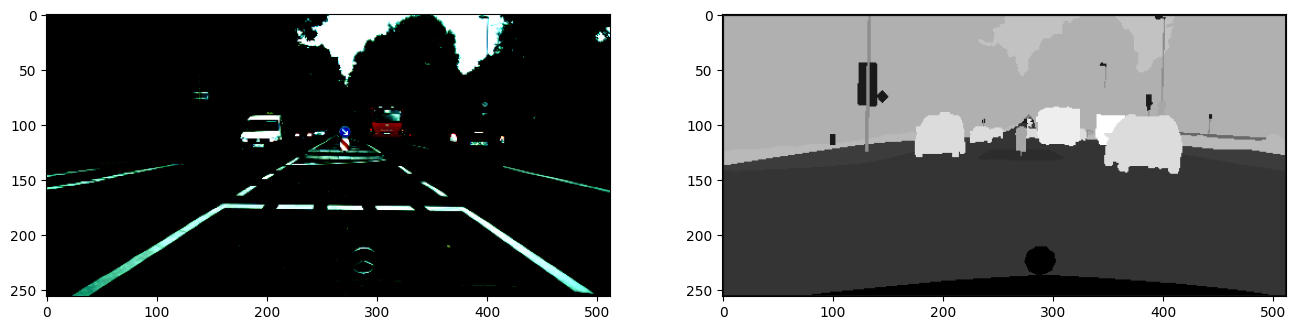

In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(seg,cmap='gray')

In [ ]:
#class labels before label correction
print(torch.unique(seg))
print(len(torch.unique(seg)))

tensor([ 1,  3,  4,  6,  7,  8, 13, 15, 17, 20, 21, 22, 23, 26, 27, 28, 30],
       dtype=torch.uint8)
17


In [ ]:
#class labels after label correction
res=encode_segmap(seg.clone())
print(res.shape)
print(torch.unique(res))
print(len(torch.unique(res)))

torch.Size([256, 512])
tensor([0, 1], dtype=torch.uint8)
2


In [ ]:
#adding colors
res1=decode_segmap(res.clone())

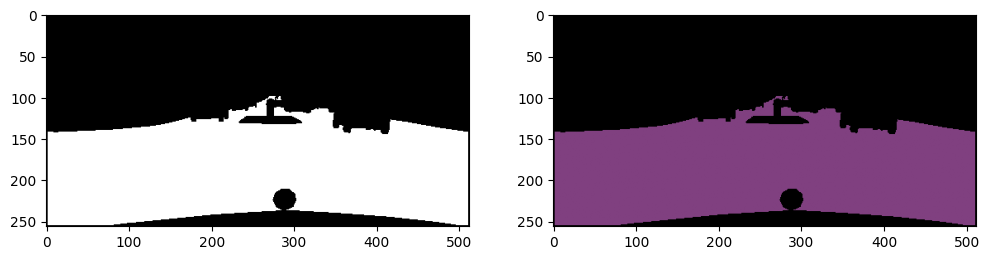

In [ ]:
fig,ax=plt.subplots(ncols=2,figsize=(12,10))  
ax[0].imshow(res,cmap='gray')
ax[1].imshow(res1)


In [ ]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=3138265c8a6f518d04c9f603b7ecfe5afb85271111bad19493cfab49b8b184ac
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=d78e3ce6c8babc8a01d2ad0eb0ece4f3d76699848168b0ca893fb4af8f408e36
  Stored in directory: /root/.cache/pip/w

In [ ]:
!pip install pytorch-lightning


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.2 MB/s eta 0:00:00


In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
from pytorch_lightning.callbacks import Callback
import segmentation_models_pytorch as smp

In [ ]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
import multiprocessing
import torchmetrics
import torch
class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer = smp.DeepLabV3(
                encoder_name="resnet18",        
                encoder_weights="imagenet",     #  `imagenet` pre-trained weights
                in_channels=3,                  # model input channels
                classes=n_classes,                      # model output channels (no.of classes)
            )
  
  #parameters
    self.lr=1e-3
    self.batch_size=32
    self.numworker=multiprocessing.cpu_count()//4

    self.criterion= smp.losses.DiceLoss(mode='multiclass')
    self.metrics = torchmetrics.JaccardIndex(num_classes=n_classes,task='multiclass')
    
    self.train_class = MyClass('/content/data/', split='train', mode='fine',
                     target_type='semantic',transforms=transform)
    self.val_class = MyClass('/content/data/', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
    
    
  def process(self,image,segment):
    out=self(image)
    segment=encode_segmap(segment)
    loss=self.criterion(out,segment.long())
    iou=self.metrics(out,segment)
    return loss,iou
    
  def forward(self,x):
    return self.layer(x)


  def configure_optimizers(self):
    opt=torch.optim.AdamW(self.parameters(), lr=self.lr)
    return opt

  def train_dataloader(self):
    return DataLoader(self.train_class, batch_size=self.batch_size, 
                      shuffle=True,num_workers=self.numworker,pin_memory=True)

  def training_step(self,batch,batch_idx):
    image,segment=batch
    loss,iou=self.process(image,segment)
    self.log('train_loss', loss,on_step=False, on_epoch=True,prog_bar=True)
    self.log('train_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
    return loss

  def val_dataloader(self):
    return DataLoader(self.val_class, batch_size=self.batch_size, 
                      shuffle=False,num_workers=self.numworker,pin_memory=True)
    
  def validation_step(self,batch,batch_idx):
    image,segment=batch
    loss,iou=self.process(image,segment)
    self.log('val_loss', loss,on_step=False, on_epoch=True,prog_bar=False)
    self.log('val_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
    return loss

In [ ]:
model = OurModel()
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath='checkpoints',
                                        filename='file',save_last=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 296MB/s]


In [ ]:
import matplotlib.pyplot as plt

# class LossPrinterCallback(Callback):
#     def __init__(self):
#         self.train_loss_values = []
#         self.val_loss_values = []
#         self.train_iou_values = []
#         self.val_iou_values = []
#         self.epochs = []

#     def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
#         training_loss = outputs["loss"].item()
#         self.train_loss_values.append(training_loss)

#         if "iou" in outputs:
#             training_iou = outputs['iou'].item()
#             self.train_iou_values.append(training_iou)

#     def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
#         val_loss = outputs['val_loss'].item()
#         self.val_loss_values.append(val_loss)

#         if "val_iou" in outputs:
#             val_iou = outputs['val_iou'].item()
#             self.val_iou_values.append(val_iou)

#     def on_validation_epoch_end(self, trainer, pl_module):
#         self.epochs.append(trainer.current_epoch + 1)

#     def on_train_end(self, trainer, pl_module):
#         plt.figure()
#         plt.plot(self.epochs, self.train_loss_values, label='Training Loss')
#         plt.plot(self.epochs, self.val_loss_values, label='Validation Loss')
#         plt.xlabel('Epoch')
#         plt.ylabel('Loss')
#         plt.title('Training and Validation Loss Curves')
#         plt.legend()
#         plt.show()

#         if len(self.train_iou_values) > 0 and len(self.val_iou_values) > 0:
#             plt.figure()
#             plt.plot(self.epochs, self.train_iou_values, label='Training IoU')
#             plt.plot(self.epochs, self.val_iou_values, label='Validation IoU')
#             plt.xlabel('Epoch')
#             plt.ylabel('IoU')
#             plt.title('Training and Validation IoU Curves')
#             plt.legend()
#             plt.show()
class LossPrinterCallback(Callback):
    def __init__(self):
        super(LossPrinterCallback, self).__init__()
        self.train_loss_values = []
        self.train_iou_values = []
        self.val_loss_values = []
        self.val_iou_values = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get("train_loss")
        train_iou = trainer.callback_metrics.get("train_iou")
        val_loss = trainer.callback_metrics.get("val_loss")
        val_iou = trainer.callback_metrics.get("val_iou")

        self.train_loss_values.append(train_loss.item())
        self.train_iou_values.append(train_iou.item())
        self.val_loss_values.append(val_loss.item())
        self.val_iou_values.append(val_iou.item())

    def on_train_end(self, trainer, pl_module):
      self.plot_losses()

    def plot_losses(self):
        epochs = len(self.train_loss_values)
        x = np.arange(1, epochs + 1)

        fig, axs = plt.subplots(2, figsize=(8, 6))
        fig.tight_layout()

        axs[0].plot(x, self.train_loss_values, label='Train Loss')
        axs[0].plot(x, self.val_loss_values, label='Validation Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend()

        axs[1].plot(x, self.train_iou_values, label='Train IoU')
        axs[1].plot(x, self.val_iou_values, label='Validation IoU')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('IoU')
        axs[1].legend()

        plt.show()

In [ ]:
trainer = Trainer(max_epochs=25,
                 precision=16,
                  callbacks=[checkpoint_callback, LossPrinterCallback()],
                 )

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | layer     | DeepLabV3              | 15.9 M
1 | criterion | DiceLoss               | 0     
2 | metrics   | MulticlassJaccardIndex | 0     
-----------------------------------------------------
15.9 M    Trainable params
0         Non-trainable params
15.9 M    Total params
63.597    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


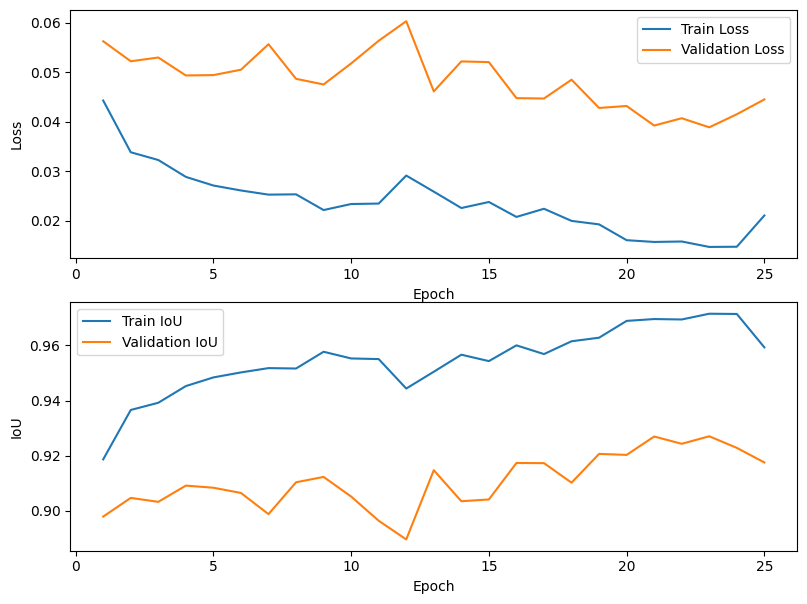

In [ ]:
trainer.fit(model)
torch.save(model.state_dict(), 'modelDeepLabV3_25.pth')

In [ ]:
from google.colab import files

files.download('modelDeepLabV3_25.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.load_state_dict(torch.load('modelDeepLabV3_25.pth'))

<All keys matched successfully>

In [ ]:
test_class = MyClass('/content/data/', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
test_loader=DataLoader(test_class, batch_size=12, 
                      shuffle=False)

In [ ]:
model=model.cuda()
model.eval()
with torch.no_grad():
    for batch in test_loader:
        img,seg=batch
        output=model(img.cuda())
        break
print(img.shape,seg.shape,output.shape) 

torch.Size([12, 3, 256, 512]) torch.Size([12, 256, 512]) torch.Size([12, 2, 256, 512])


In [ ]:
from torchvision import transforms
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)

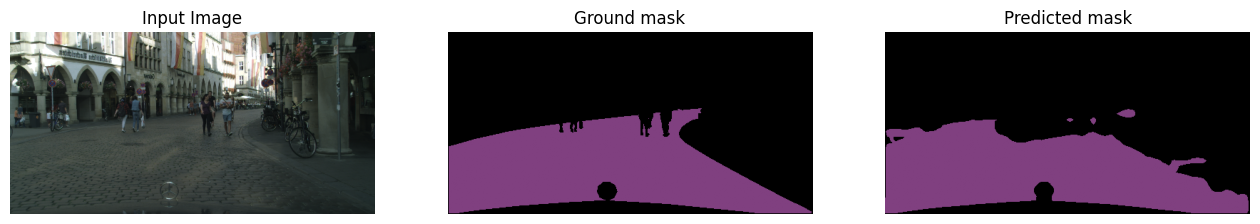

In [ ]:
sample=7
invimg=inv_normalize(img[sample])
outputx=output.detach().cpu()[sample]
encoded_mask=encode_segmap(seg[sample].clone()) #(256, 512)
decoded_mask=decode_segmap(encoded_mask.clone())  #(256, 512)
decoded_ouput=decode_segmap(torch.argmax(outputx,0))
fig,ax=plt.subplots(ncols=3,figsize=(16,50),facecolor='white')  
ax[0].imshow(np.moveaxis(invimg.numpy(),0,2)) #(3,256, 512)
#ax[1].imshow(encoded_mask,cmap='gray') #(256, 512)
ax[1].imshow(decoded_mask) #(256, 512, 3)
ax[2].imshow(decoded_ouput) #(256, 512, 3)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Input Image')
ax[1].set_title('Ground mask')
ax[2].set_title('Predicted mask')
plt.savefig('result.png',bbox_inches='tight')

In [ ]:
from PIL import Image
import torchvision.transforms.functional as F_t
import torch

# Load the image
image = Image.open('/content/image4.jpg')

# Resize the image
resized_image = image.resize((864, 480)) 

# Convert the resized image to a tensor
tensor_image = F_t.to_tensor(resized_image)


# # Ensure the tensor image has the correct size and shape
if tensor_image.shape[0] == 4:  # If the tensor has an alpha channel, remove it
    tensor_image = tensor_image[:3, :, :]


# Normalize the tensor using the same parameters used during training
mean = [0.485, 0.456, 0.406]  
std = [0.229, 0.224, 0.225]   
normalized_image = F_t.normalize(tensor_image, mean=mean, std=std)

# Add an extra dimension to the tensor to represent the batch size
input_tensor = normalized_image.unsqueeze(0)

# Move the tensor to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)

<Figure size 640x480 with 0 Axes>

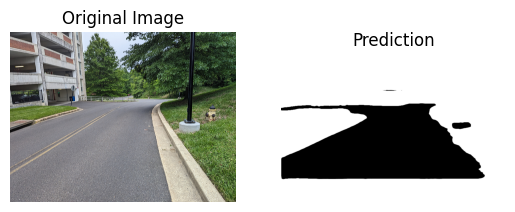

In [ ]:
import cv2
# image_tensor = torch.from_numpy(input_tensor).float()
with torch.no_grad():
  output = model(input_tensor)

output = output.cpu()

# Convert the output tensor to a NumPy array
output_np = output.numpy()

for i, prediction in enumerate(output_np):
    # Plot the prediction for each sample in the test data
    plt.figure()
    if len(prediction.shape) == 3 and prediction.shape[0] == 1:
      prediction = prediction.squeeze(0)
# plt.imshow(prediction[0])
# plt.title(f"Sample {i+1} - Prediction")
# plt.axis('off')
# plt.show()



fig, (ax1, ax2) = plt.subplots(1, 2)

# Display the original image
ax1.imshow(image)
ax1.set_title("Original Image")
ax1.axis('off')

# Display the prediction
if len(output_np.shape) == 3 and output_np.shape[0] == 1:
    output_np = output_np.squeeze(0)
rgb_image = cv2.cvtColor(prediction[0], cv2.COLOR_BGR2RGB)
ax2.imshow(rgb_image)
ax2.set_title("Prediction")
ax2.axis('off')

plt.show()